# Group Project 4

# Air Quality and Mortality

imports 

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os


from sklearn.linear_model import PoissonRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

# variance inflation factor
from statsmodels.stats.outliers_influence import variance_inflation_factor

read in EPA air_quality .csv files

In [3]:
# # read in each CSV file in air_quality_data directory and concatenate them into one dataframe
air_quality_data = pd.concat([pd.read_csv('air_quality_data/{}'.format(file)) for file in os.listdir('air_quality_data')])

# daily air quality data
air_quality_data_daily = pd.concat([pd.read_csv('daily_air_quality_data/{}'.format(file), low_memory=False) for file in os.listdir('daily_air_quality_data')])

# life expectancy data by CA county
life_expectancy = pd.read_csv('health_data/Vital_Signs_Life_Expectancy_by_county.csv')

# mortality tables for CA counties from 2014-2022
mortality = pd.read_csv('health_data/mortality.csv')

# mortality tables for CA counties from 1999-2013
mortality_2 = pd.read_csv('health_data/99-13_mortality.csv')

# concatenate the two mortality tables
mortality = pd.concat([mortality, mortality_2]).sort_values(by='Year').reset_index(drop=True)

# rename Year to Date
mortality.rename(columns={'Year':'Date'}, inplace=True)

# monthly mortality data 
mortality_data_monthly = pd.concat([pd.read_csv('monthly_health_data/{}'.format(file)) for file in os.listdir('monthly_health_data')])

# 5 year cancer incidence rates by CA county
cancer_incidence = pd.read_csv('health_data/incd.csv')

Filter `air_quality_data` down to only California

In [4]:
# filter for only California 
ca_df = air_quality_data.query('State == "California"').copy()

# Set the index to be the year
ca_df.set_index('Year', inplace=True)

# rename Year to Date
ca_df.index.rename('Date', inplace=True)

# annual air quality data
ca_df = ca_df.query('`Days with AQI` > 360').copy()

# daily air quality data
ca_df_daily = air_quality_data_daily.query('`State Name` == "California"').copy()

# datetime index
ca_df_daily.set_index(pd.to_datetime(ca_df_daily['Date']), inplace=True)

# daily to monthly
ca_df_daily = ca_df_daily.groupby('county Name').resample('MS').mean()

# rename index to 'County'
ca_df_daily.index.rename('County', level=0, inplace=True)

DateTime Index for Monthly Mortality Data

In [5]:
# combine Year and Month columns into a single column, then convert to datetime object and set as index

mortality_data_monthly['Year'] = mortality_data_monthly['Year'].astype(str)
mortality_data_monthly['Month'] = mortality_data_monthly['Month'].astype(str)
mortality_data_monthly['Date'] = mortality_data_monthly['Year'] + '-' + mortality_data_monthly['Month'] + '-01'
mortality_data_monthly['Date'] = pd.to_datetime(mortality_data_monthly['Date'])
mortality_data_monthly.set_index('Date', inplace=True)

# drop Year and Month columns
mortality_data_monthly.drop(['Year', 'Month'], axis=1, inplace=True)

# CA Mortality Statistics

| Abbreviation | Cause of Death |
| --- | --- |
| ALL | All causes (total) |
| ALZ | Alzheimer's disease [G30] |
| CAN | Malignant neoplasms (cancers) [C00-C97] |
| CLD | Chronic lower respiratory disease (CLRD) [J40-J47] |
| DIA | Diabetes mellitus [E10-E14] |
| HOM | Assault (homicide) [*U01-*U02, X85-Y09, Y87.1] |
| HTD | Diseases of heart [I00-I09, I11, I13, I20-I51] |
| HYP | Essential hypertension and hypertensive renal disease [I10, I12, I15] |
| INJ | Accidents (unintentional injuries) [V01-X59, Y85-Y86] |
| LIV | Chronic liver disease and cirrhosis [K70, K73-K74] |
| NEP | Nephritis, nephrotic syndrome and nephrosis [N00-N07, N17-N19, N25-N27] |
| PAR | Parkinson's disease [G20-G21] |
| PNF | Pneumonia and influenza [J09-J18] |
| STK | Cerebrovascular disease (stroke) [I60-I69] |
| SUI | Intentional self-harm (suicide) [*U03, X60-X84, Y87.0] |


# Annual and Monthly DataFrames for 4 major Mortalities

In [6]:
# deaths likely attributable to air pollution
respiratory_diseases = ['CLD', 'CAN', 'PNF', 'HTD']

In [7]:
# create a df for each disease

# chronic lower respiratory diseases
cld = mortality.query('Cause == "CLD" and Strata == "Total Population" and Geography_Type == "Residence"').copy()

cld_monthly = mortality_data_monthly.query('Cause == "CLD" and Strata == "Total Population" and Geography_Type == "Residence"').copy()

# cancer
can = mortality.query('Cause == "CAN" and Strata == "Total Population" and Geography_Type == "Residence"').copy()

can_monthly = mortality_data_monthly.query('Cause == "CAN" and Strata == "Total Population" and Geography_Type == "Residence"').copy()

# pneumonia
pneumonia = mortality.query('Cause == "PNF" and Strata == "Total Population" and Geography_Type == "Residence"').copy()

pneumonia_monthly = mortality_data_monthly.query('Cause == "PNF" and Strata == "Total Population" and Geography_Type == "Residence"').copy()

# heart disease
heart_disease = mortality.query('Cause == "HTD" and Strata == "Total Population" and Geography_Type == "Residence"').copy()

heart_disease_monthly = mortality_data_monthly.query('Cause == "HTD" and Strata == "Total Population" and Geography_Type == "Residence"').copy()


# Merge with EPA DATA

In [8]:
# only want full data
ca_df = ca_df.query('`Days with AQI` > 360').copy()

# merge cld and ca_df
cld = cld.merge(ca_df, how='left', left_on=['County', 'Date'], right_on=['County', 'Date'])

cld_monthly = cld_monthly.merge(ca_df_daily, how='left', left_on=['County', 'Date'], right_on=['County', 'Date'])

# merge can and ca_df
can = can.merge(ca_df, how='left', left_on=['County', 'Date'], right_on=['County', 'Date'])

can_monthly = can_monthly.merge(ca_df_daily, how='left', left_on=['County', 'Date'], right_on=['County', 'Date'])

# merge pneumonia and ca_df
pneumonia = pneumonia.merge(ca_df, how='left', left_on=['County', 'Date'], right_on=['County', 'Date'])

pneumonia_monthly = pneumonia_monthly.merge(ca_df_daily, how='left', left_on=['County', 'Date'], right_on=['County', 'Date'])

# merge heart_disease and ca_df
heart_disease = heart_disease.merge(ca_df, how='left', left_on=['County', 'Date'], right_on=['County', 'Date'])

heart_disease_monthly = heart_disease_monthly.merge(ca_df_daily, how='left', left_on=['County', 'Date'], right_on=['County', 'Date'])

# query dataframes so count is greater than 0

# chronic 
cld = cld.query('Count > 0')

# cancer
can = can.query('Count > 0')

# pneumonia
pneumonia = pneumonia.query('Count > 0')

# heart disease
heart_disease = heart_disease.query('Count > 0')

In [9]:
# impute missing values with 0

# chronic lower respiratory diseases 
cld.fillna(0, inplace=True)

# cancer
can.fillna(0, inplace=True)

# pneumonia
pneumonia.fillna(0, inplace=True)

# heart disease
heart_disease.fillna(0, inplace=True)

In [35]:
# write cld, can, pneumonia, and heart_disease to csv
cld.to_csv('merged_mortality_epa_data/cld.csv', index=False)
can.to_csv('merged_mortality_epa_data/can.csv', index=False)
pneumonia.to_csv('merged_mortality_epa_data/pneumonia.csv', index=False)
heart_disease.to_csv('merged_mortality_epa_data/heart_disease.csv', index=False)


# EDA

In [10]:
# matplotlib style 
plt.style.use('seaborn')

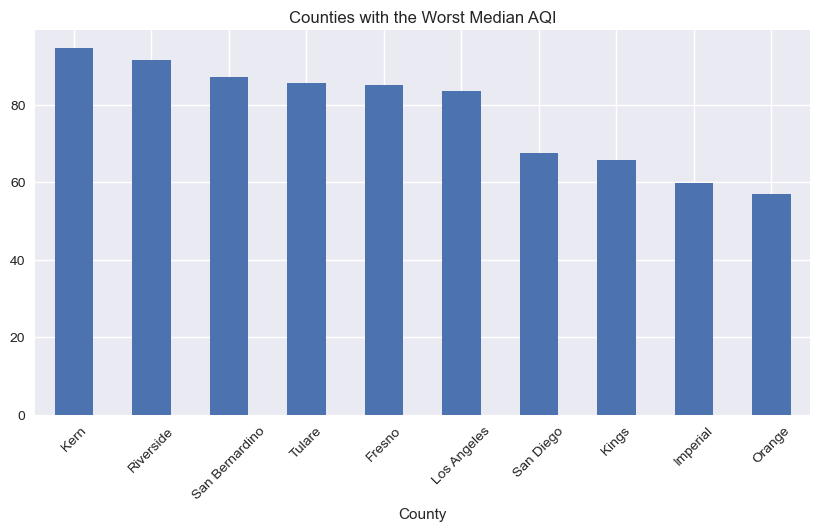

In [11]:
# counties with the most unhealthy days
counties_worst_air_qual = ca_df.groupby('County')['Median AQI'].mean().sort_values(ascending=False).head(10)

counties_worst_air_qual.plot(kind='bar', figsize=(10, 5), title='Counties with the Worst Median AQI')
plt.xticks(rotation=45);

Text(0.5, 1.0, 'Counties with the Worst Median AQI')

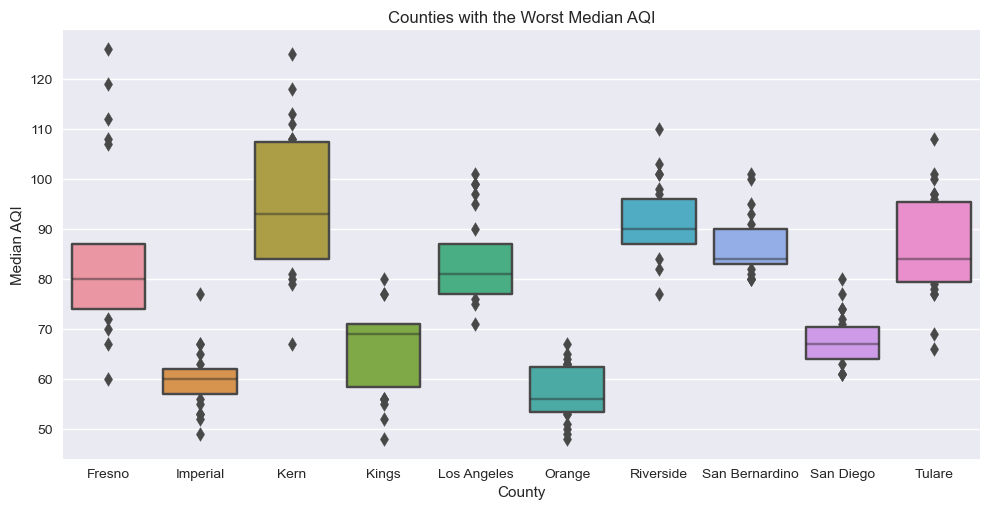

In [12]:
# tile plot of the top 10 counties with the most unhealthy days
sns.catplot(x='County', y='Median AQI', data=ca_df.query('County in @counties_worst_air_qual.index'), kind='boxen', height=5, aspect=2)
# title
plt.title('Counties with the Worst Median AQI')

In [13]:
def plot_air_quality_by_county(county, air_qual, diseases, df, air_qual_df):
    """
    Plots the number of deaths from a specified set of diseases in a given county, 
    and the amount of specified air quality days in that county, on separate subplots.
    
    Args:
        county (str): The name of the county to plot data for.
        air_qual (str): The type of air quality to plot data for.
        diseases (list): A list of strings representing the names of the diseases to plot data for.
    """
    # create figure and subplots
    fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

    # query mortality df
    df.query(f'County == "{county}" and Strata == "Total Population" and Cause in {diseases}').groupby('Date')['Count'].sum().plot(kind='line', figsize=(10, 5), title=f'Deaths from {diseases} in {county} by Date', ax=ax[0])
    

    # overlay line plot of unhealthy days from ca_df log scale
    air_qual_df.query(f'County == "{county}"').groupby('Date')[air_qual].sum().plot(kind='line', figsize=(10, 5), title=f'{air_qual} in {county} by Date', ax=ax[1], color='red')

    # tight layout
    plt.tight_layout()
    
    # close figure
    plt.show()
    plt.close()

# function to plot correlation matrix for air quality and disease df
def get_correlation_plot(df, title):
    """
    Plots the upper triangle of the correlation matrix for a given dataframe.
    
    Args:
        df (pd.DataFrame): The dataframe to plot the correlation matrix for.
    """
    # create figure and axis
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # plot heatmap
    sns.heatmap(df, annot=True, cmap='coolwarm', vmin=-1, vmax=1, mask=np.triu(df, k=1), ax=ax)
    plt.xticks(rotation=45, ha='right')
    plt.title(title)
    # tight layout
    plt.tight_layout()
    
    # close figure
    plt.show()
    plt.close()


# Granger Causality Tests

In [14]:
from statsmodels.tsa.stattools import grangercausalitytests

# Perform the Granger causality test
maxlag = 2 # number of lags to consider

# Null hypothesis: x does not Granger cause y
# Alternative hypothesis: x Granger causes y

def air_qual_test(df, air_qual_stat):
    for county in counties_worst_air_qual.index:
        try:
            # perform granger causality test
            result = grangercausalitytests(df.query(f'County == "{county}"')[['Count', air_qual_stat]], maxlag=maxlag, verbose=False)
            # get lag 1 p values
            lag1 = np.array([result[1][0][key][1] for key in result[1][0].keys()]).mean()
            # get lag 2 p values
            lag2 = np.array([result[2][0][key][1] for key in result[1][0].keys()]).mean()
            # alpha = 0.05 
            if lag1 < 0.05:
                print(f'Air Quality metric: ({air_qual_stat}) Granger causes deaths from respiratory diseases in {county} county with p_value of {lag1} and lag of 1')
                return county, air_qual_stat, lag1, 1, df['Cause'].unique()[0]
            elif lag2 < 0.05:
                print(f'Air Quality metric: ({air_qual_stat}) Granger causes deaths from respiratory diseases in {county} county with p_value of {lag2} and lag of 2')
                return county, air_qual_stat, lag2, 2, df['Cause'].unique()[0]
            else:
                pass
        except:
            print('Air quality metric not in dataset.')

counties = []
# test for each air quality stat
    # add dicts to counties dict
for df in [cld, can, pneumonia, heart_disease]:
    for air_qual_stat in ['Days PM2.5', 'Days NO2', 'Days Ozone', 'Days PM10', 'Unhealthy Days', 'Median AQI']:
        counties.append(air_qual_test(df, air_qual_stat))
        

granger_df = pd.DataFrame(counties, columns=['County','air_qual_metric','p_value', 'lag', 'Cause'])

granger_df.sort_values(by='County', ascending=True, inplace=True)

granger_df.dropna(inplace=True)
granger_df

Air Quality metric: (Days PM2.5) Granger causes deaths from respiratory diseases in San Bernardino county with p_value of 0.031085038233294383 and lag of 1
Air Quality metric: (Days NO2) Granger causes deaths from respiratory diseases in Kern county with p_value of 0.02326467298395096 and lag of 1
Air Quality metric: (Days PM10) Granger causes deaths from respiratory diseases in Riverside county with p_value of 0.04112011440054087 and lag of 1
Air Quality metric: (Unhealthy Days) Granger causes deaths from respiratory diseases in San Bernardino county with p_value of 0.010429616891486249 and lag of 1
Air Quality metric: (Median AQI) Granger causes deaths from respiratory diseases in San Diego county with p_value of 0.011725205909490083 and lag of 2
Air Quality metric: (Days PM2.5) Granger causes deaths from respiratory diseases in Los Angeles county with p_value of 0.0037490376870667587 and lag of 1
Air Quality metric: (Days NO2) Granger causes deaths from respiratory diseases in Kern 

,County,air_qual_metric,p_value,lag,Cause
19,Imperial,Days NO2,0.013743,1.0,HTD
1,Kern,Days NO2,0.023265,1.0,CLD
18,Kern,Days PM2.5,0.006126,2.0,HTD
7,Kern,Days NO2,0.008690,1.0,CAN
17,Kern,Median AQI,0.021730,1.0,PNF
10,Kern,Unhealthy Days,0.004728,1.0,CAN
20,Kern,Days Ozone,0.018678,2.0,HTD
16,Kern,Unhealthy Days,0.003019,1.0,PNF
13,Kern,Days NO2,0.020468,1.0,PNF
6,Los Angeles,Days PM2.5,0.003749,1.0,CAN


In [36]:
# write granger_df to csv
granger_df.to_csv('merged_mortality_epa_data/granger_df.csv', index=False)

# Correlation Plots

In [16]:
# numeric columns in ca_df
numeric_cols = ['Good Days', 'Moderate Days', 'Unhealthy Days', 'Very Unhealthy Days', 'Hazardous Days', 'Max AQI', 'Days CO', 'Days NO2', 'Days Ozone', 'Days PM2.5', 'Days PM10', 'Days with AQI', 'Count', 'Median AQI']

# query for worst counties for each disease
cld_corr = cld.query('County in @counties_worst_air_qual.index')[numeric_cols].corr()

can_corr = can.query('County in @counties_worst_air_qual.index')[numeric_cols].corr()

pneumonia_corr = pneumonia.query('County in @counties_worst_air_qual.index')[numeric_cols].corr()

heart_disease_corr = heart_disease.query('County in @counties_worst_air_qual.index')[numeric_cols].corr()


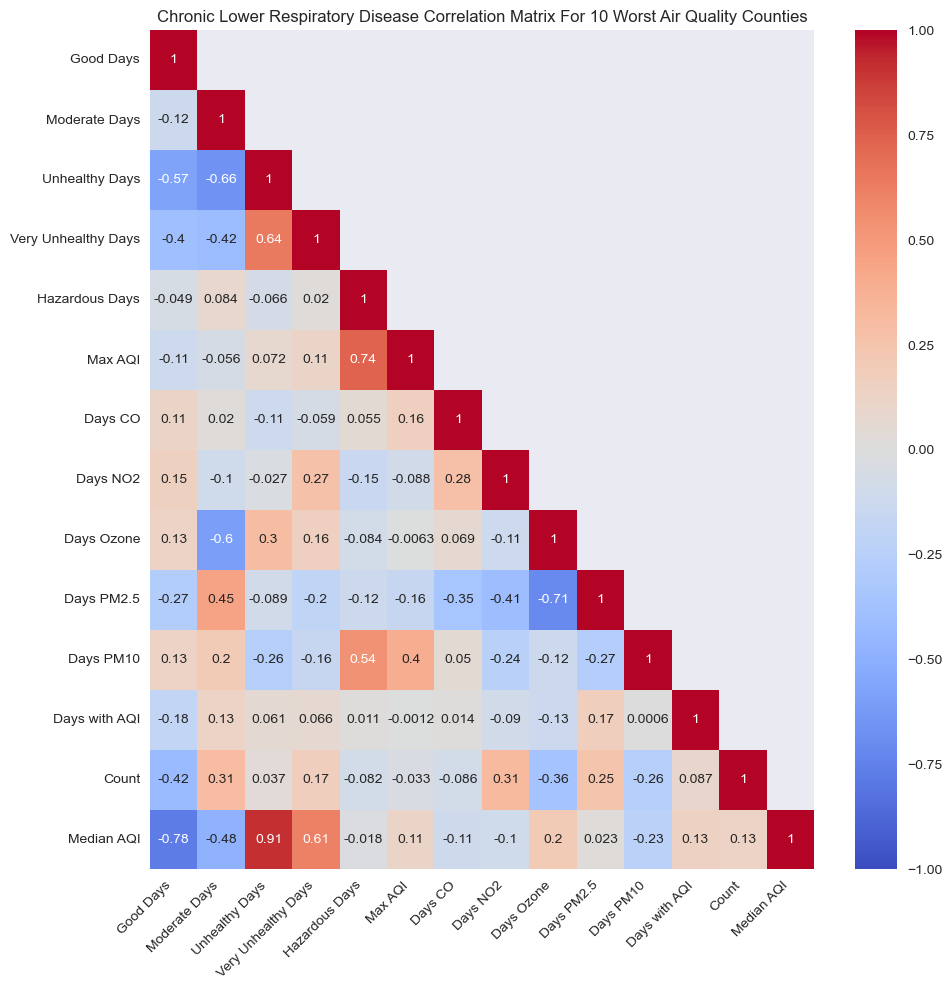

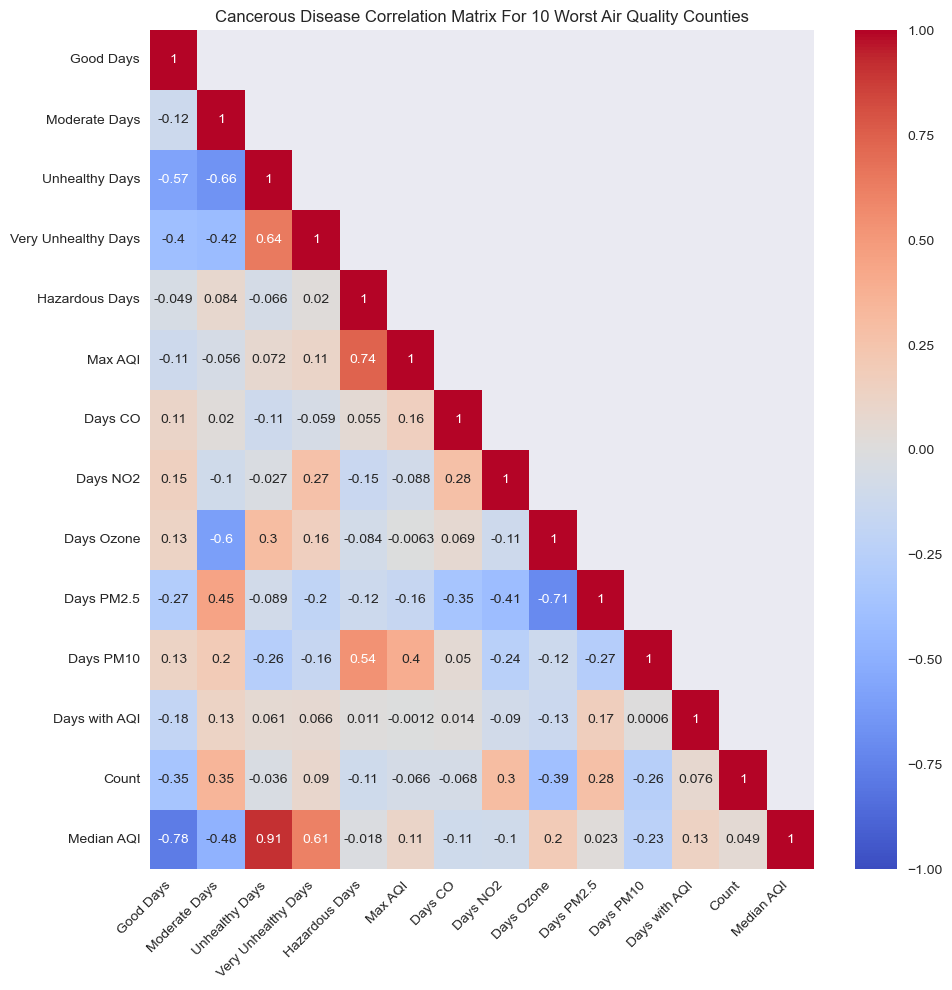

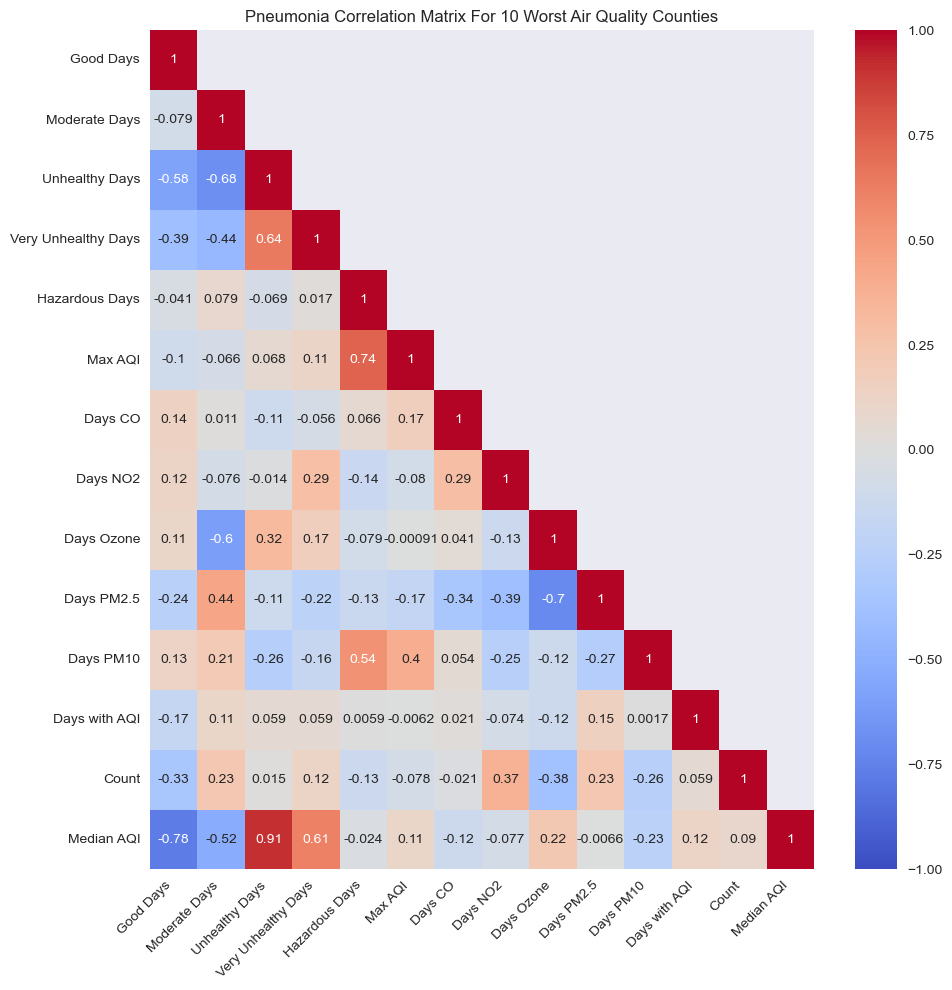

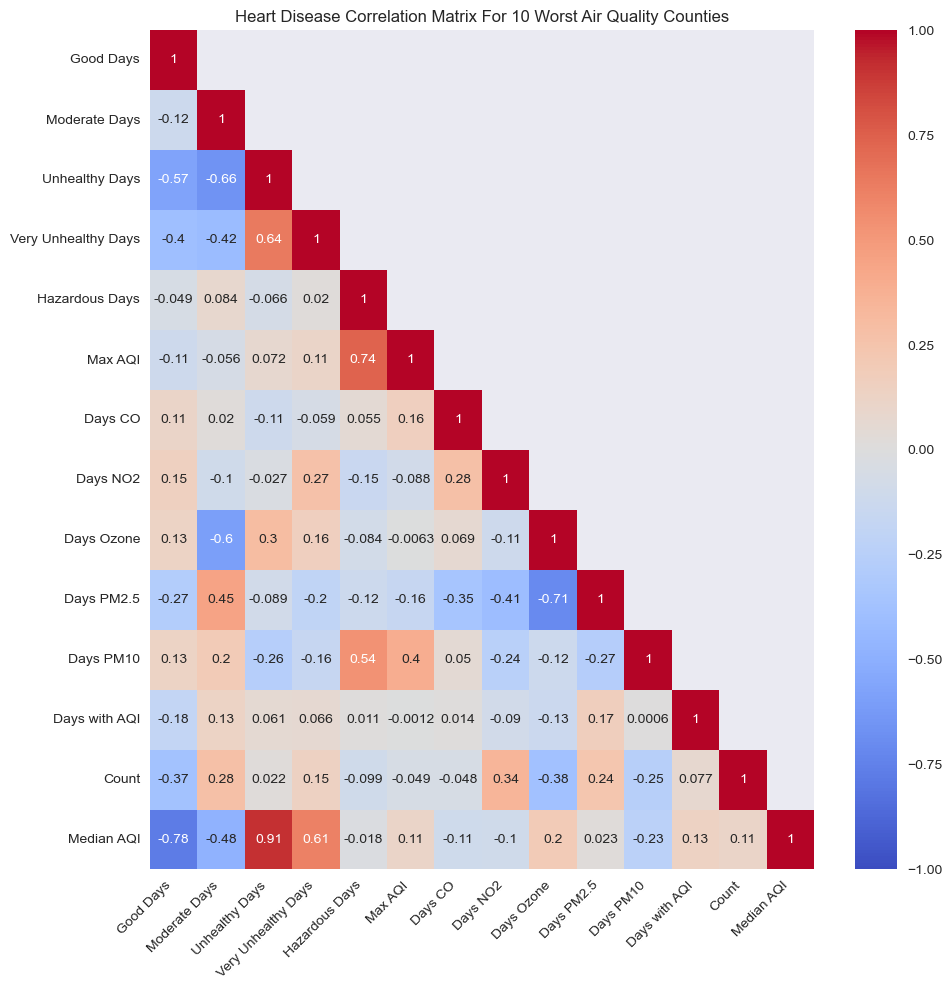

In [17]:
# CLD
get_correlation_plot(cld_corr, 'Chronic Lower Respiratory Disease Correlation Matrix For 10 Worst Air Quality Counties')

# CAN
get_correlation_plot(can_corr, 'Cancerous Disease Correlation Matrix For 10 Worst Air Quality Counties')

# PNF
get_correlation_plot(pneumonia_corr, 'Pneumonia Correlation Matrix For 10 Worst Air Quality Counties')

# HTD
get_correlation_plot(heart_disease_corr, 'Heart Disease Correlation Matrix For 10 Worst Air Quality Counties')

# Line Plots From Annual Granger Tests

Annual Data

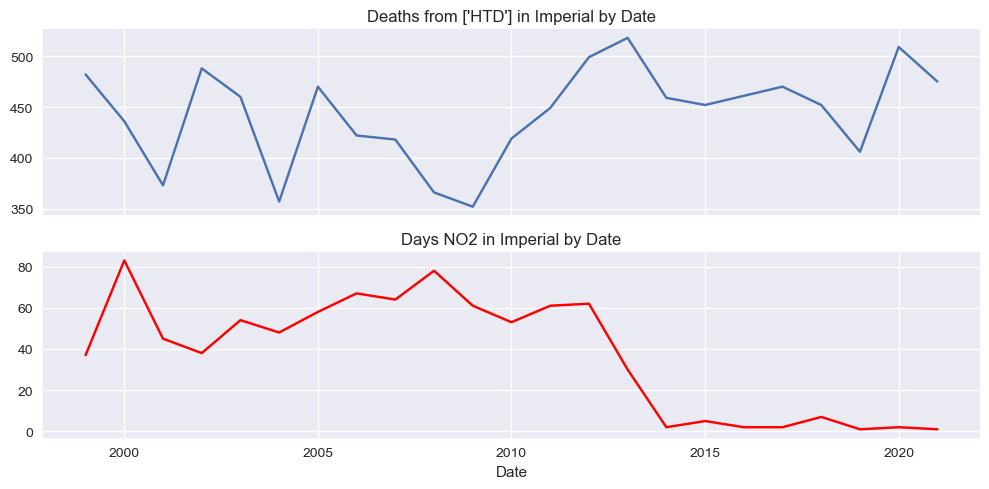

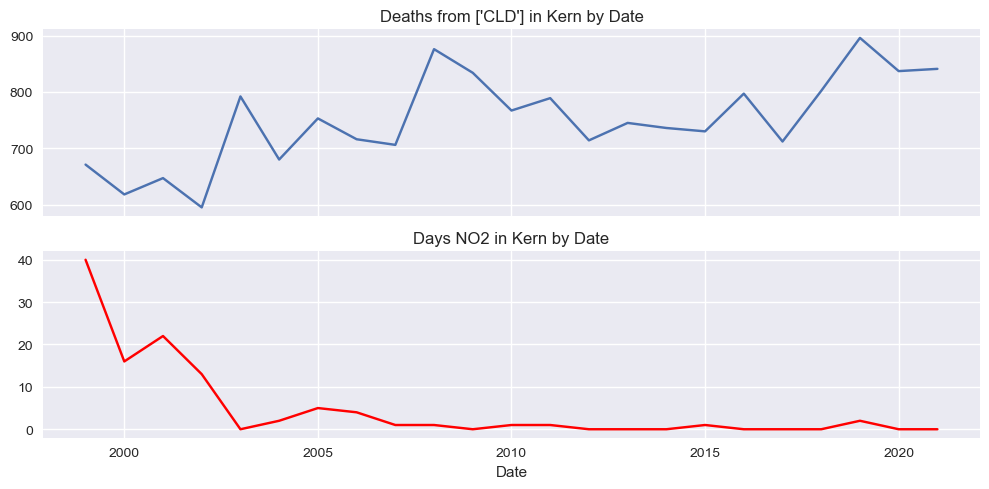

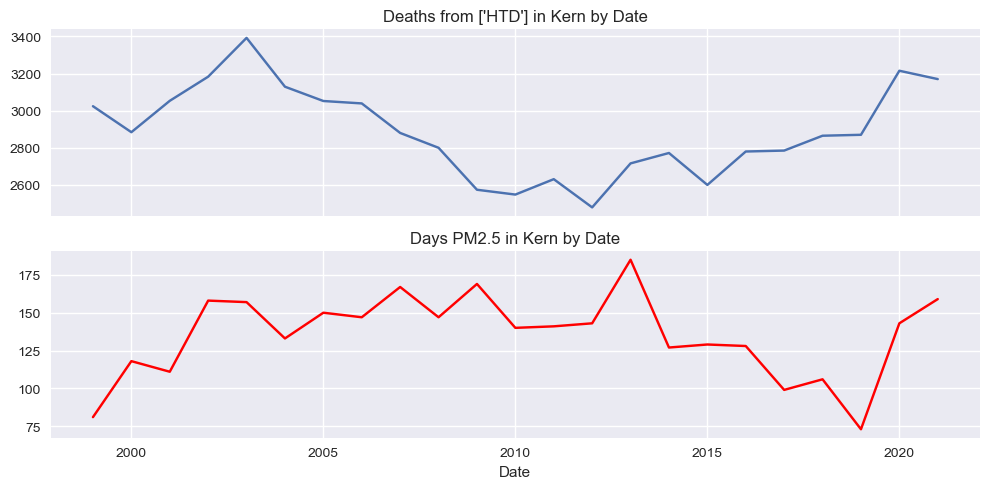

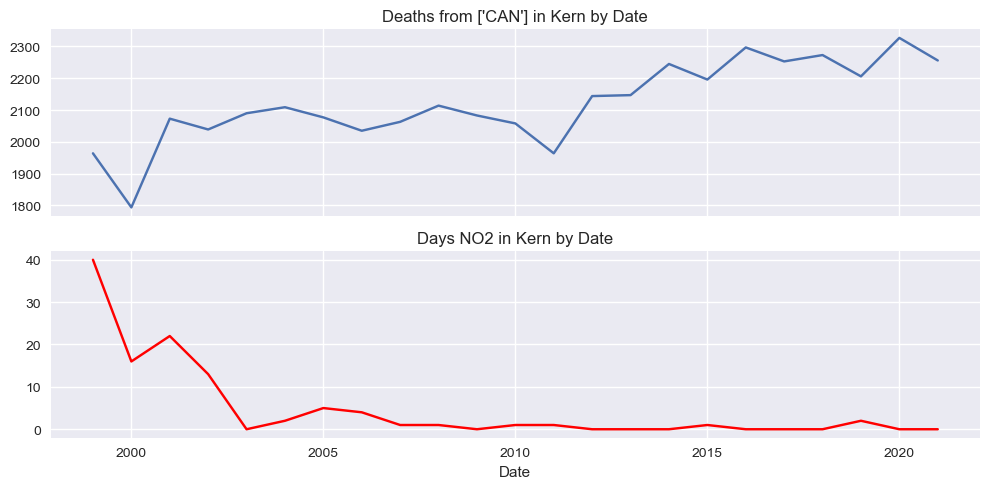

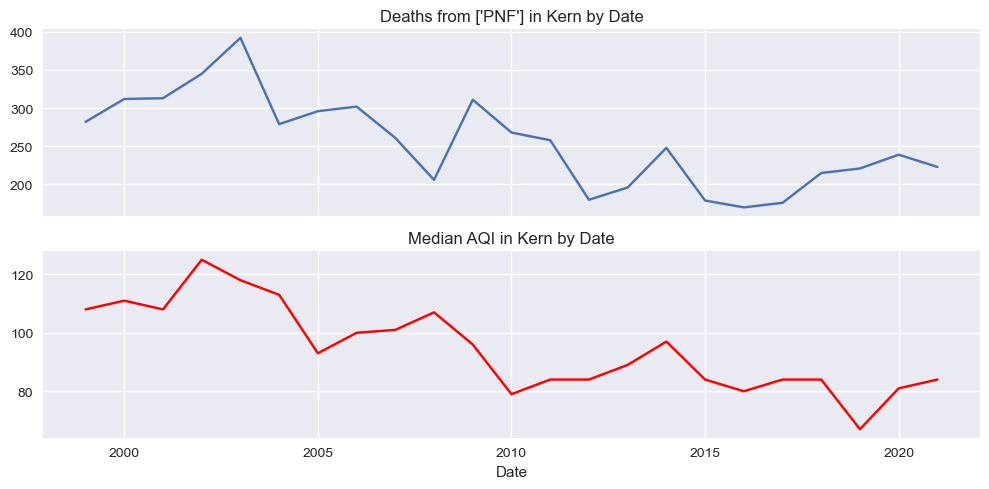

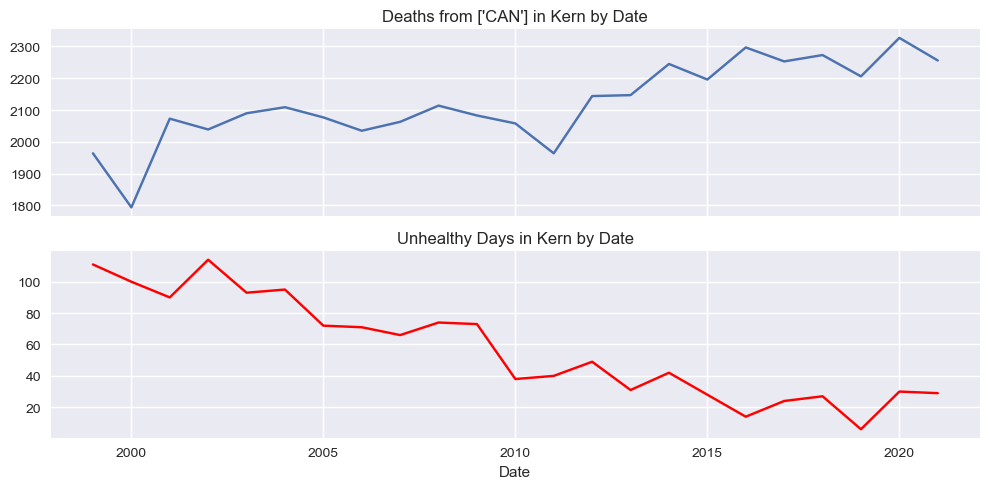

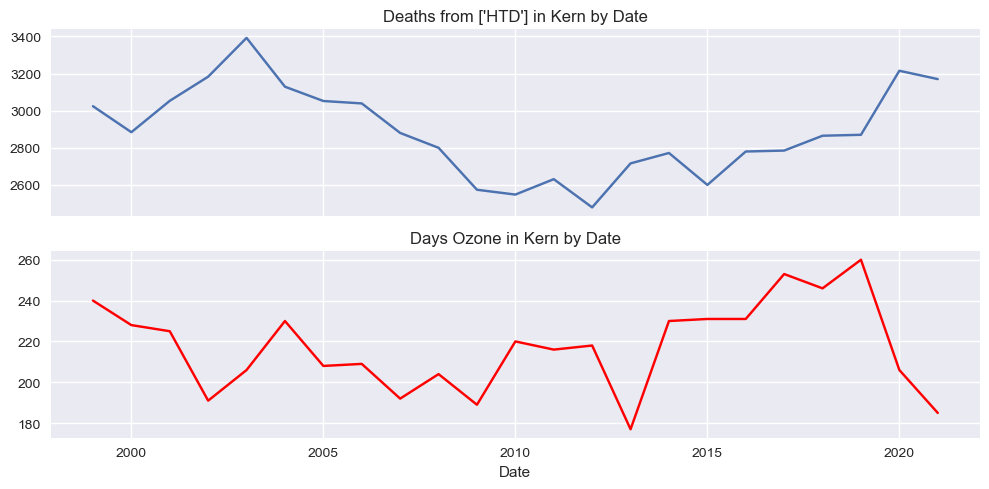

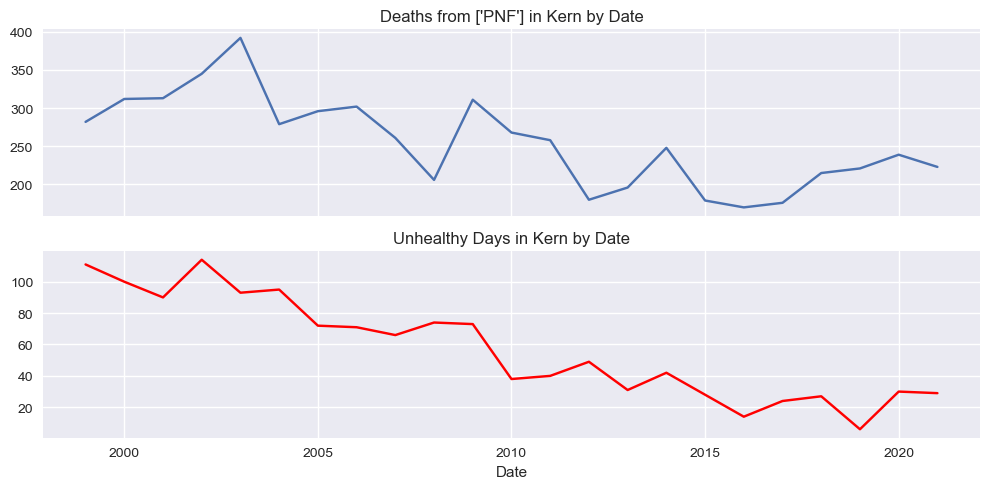

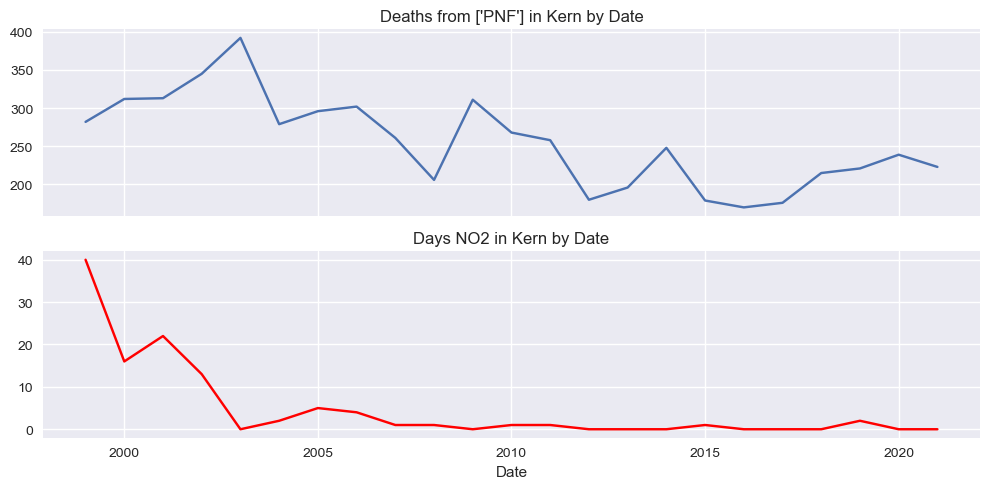

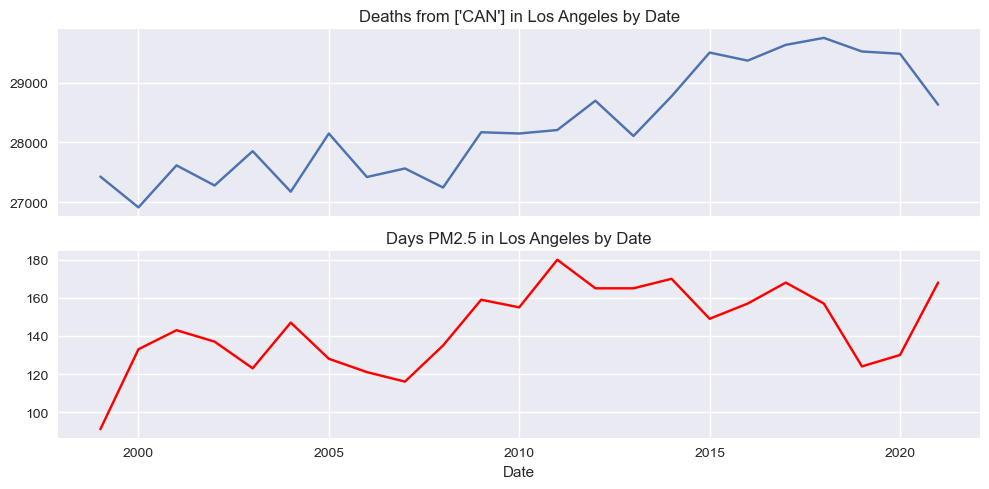

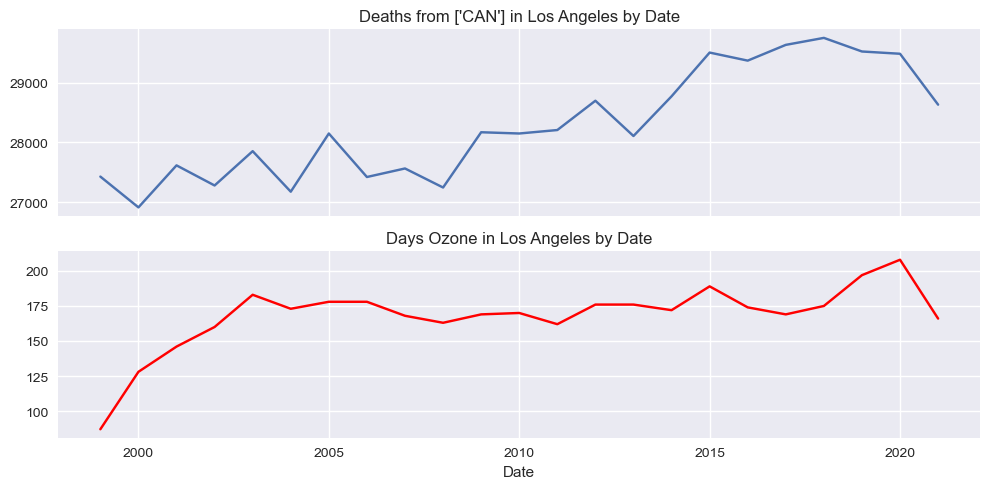

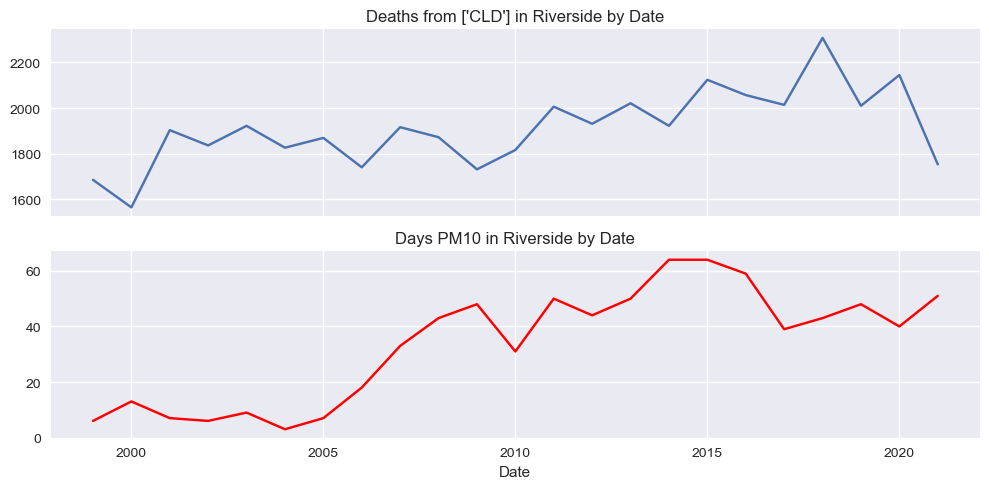

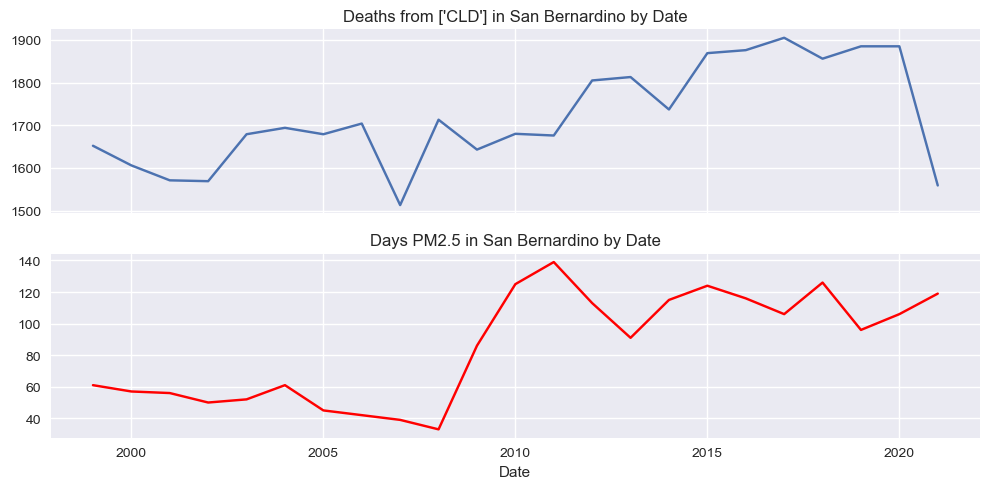

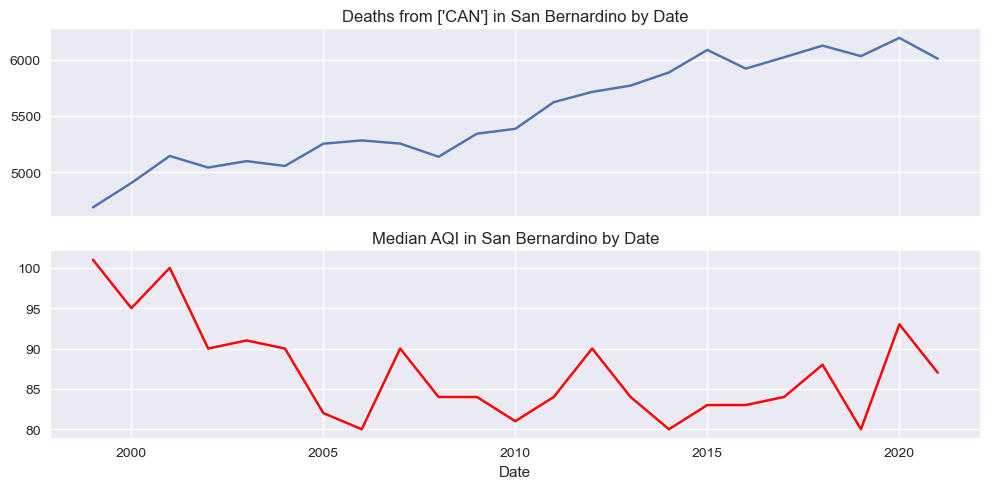

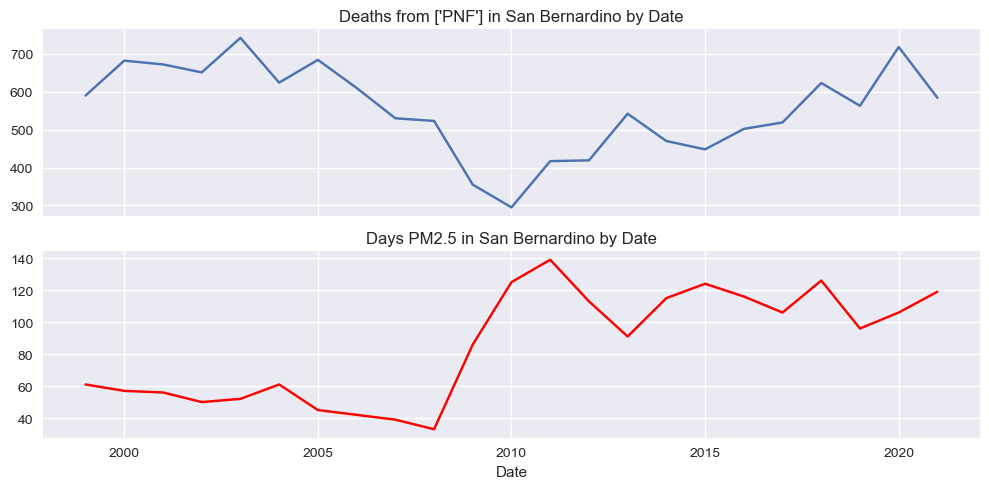

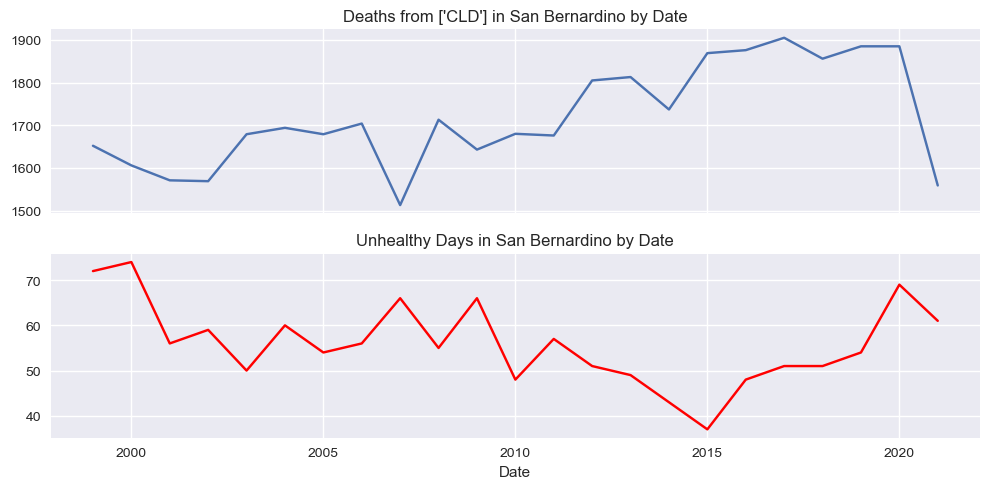

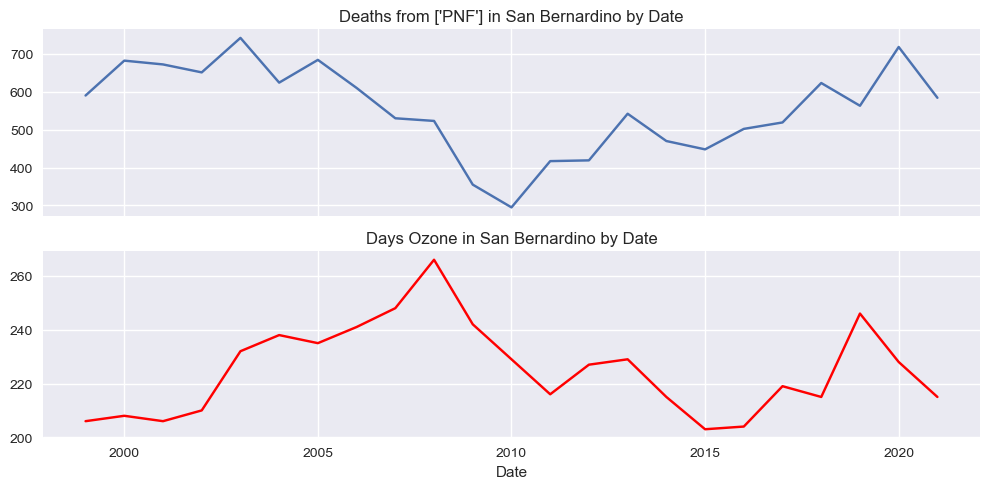

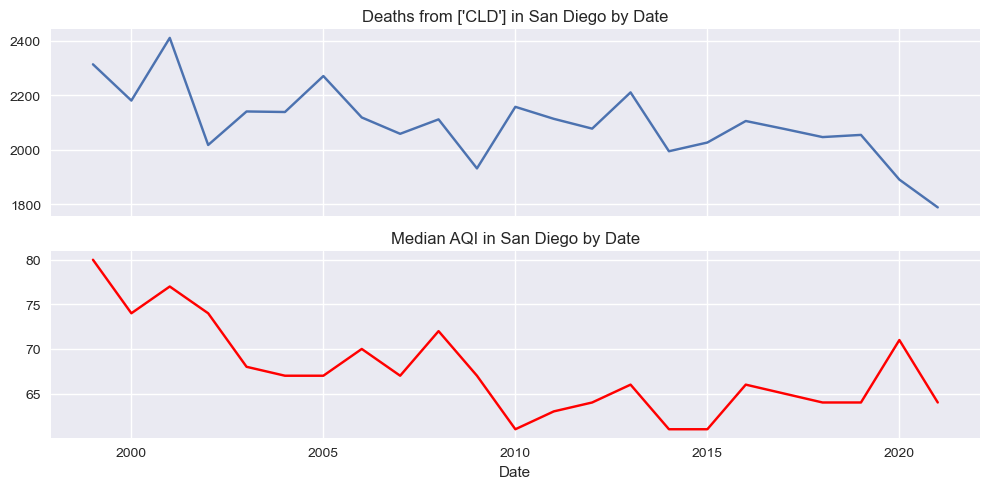

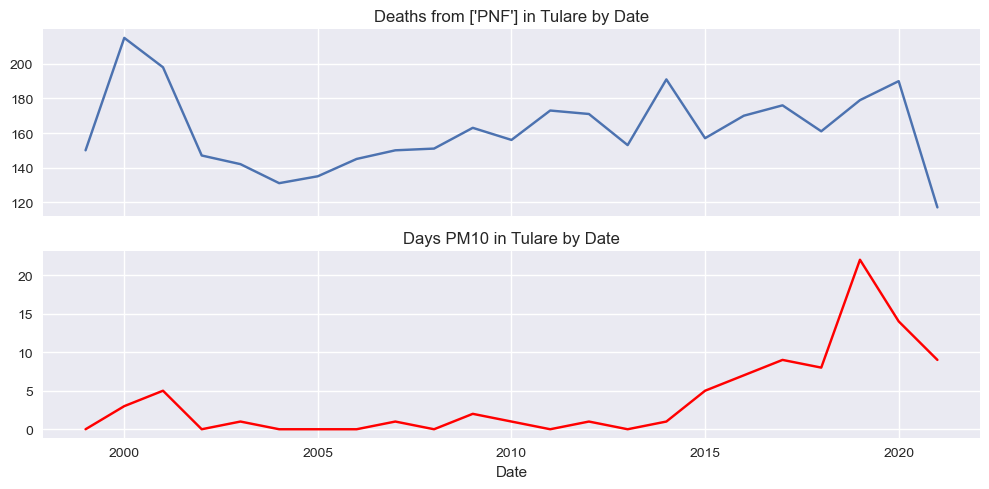

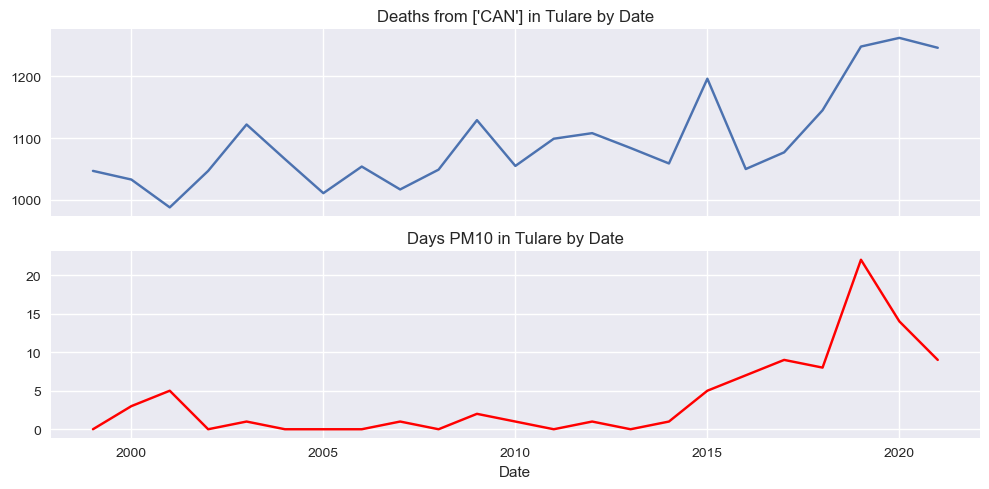

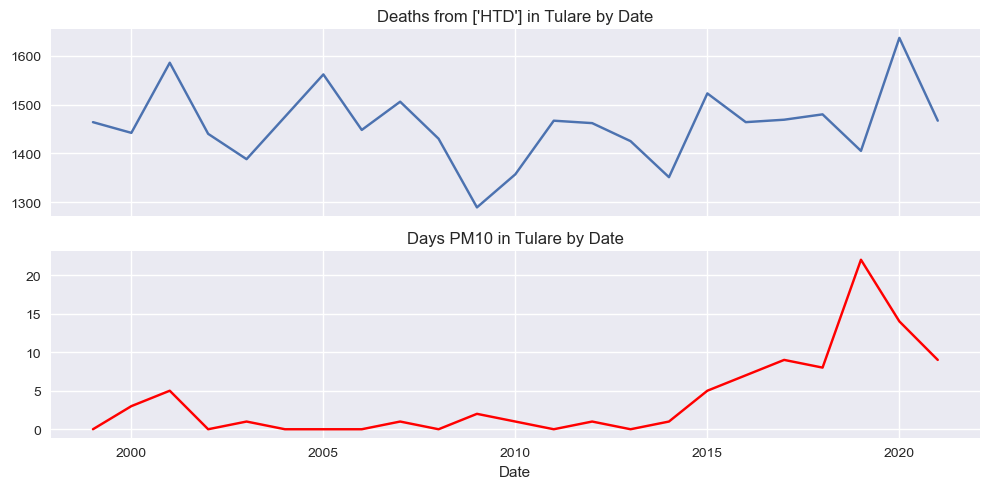

In [18]:
for county in granger_df.iterrows():
    try:
        plot_air_quality_by_county(county[1]['County'], county[1]['air_qual_metric'], [county[1]['Cause']], df=mortality, air_qual_df=ca_df)
    except:
        pass

# Granger Tests and Plots For Monthly Data

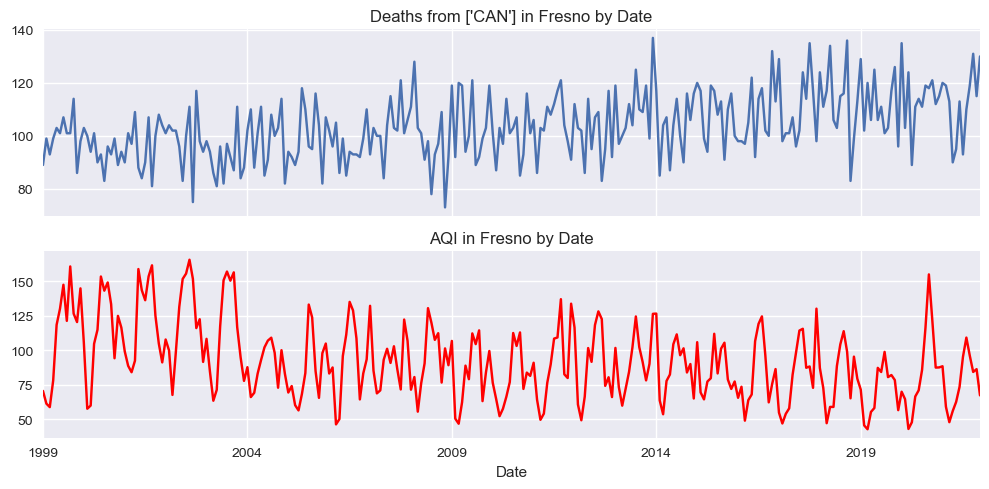

Air Quality metric: (AQI) Granger causes deaths from respiratory diseases in Fresno county with p_value of 0.030338266113974638 and lag of 1


('Fresno', 'AQI', 0.030338266113974638, 1, 'CAN')

In [19]:
plot_air_quality_by_county(county='Fresno', air_qual='AQI', diseases=['CAN'], df=can_monthly, air_qual_df=can_monthly)
air_qual_test(can_monthly, 'AQI')

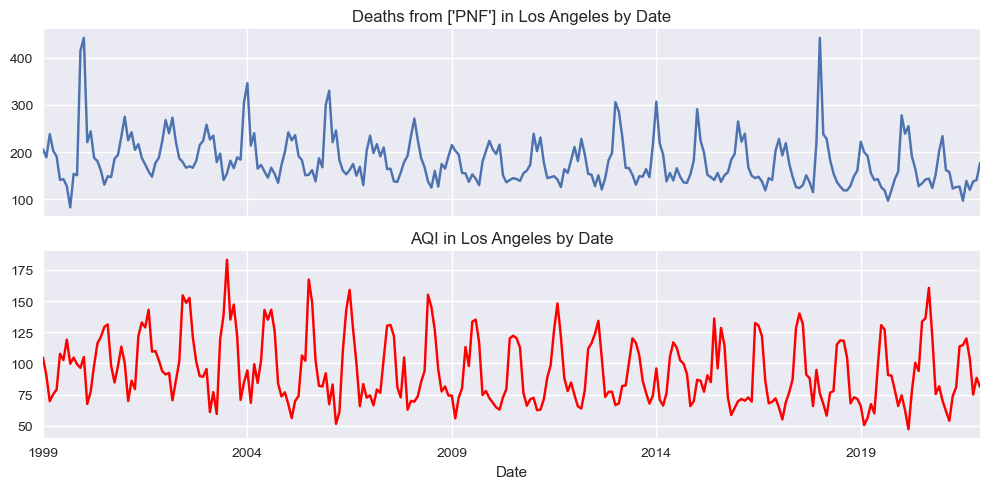

Air quality metric not in dataset.
Air quality metric not in dataset.
Air quality metric not in dataset.
Air quality metric not in dataset.
Air quality metric not in dataset.
Air Quality metric: (AQI) Granger causes deaths from respiratory diseases in Los Angeles county with p_value of 0.0012576841495153576 and lag of 1


('Los Angeles', 'AQI', 0.0012576841495153576, 1, 'PNF')

In [20]:
plot_air_quality_by_county(county = 'Los Angeles', air_qual = 'AQI', diseases = ['PNF'], df = pneumonia_monthly, air_qual_df = pneumonia_monthly)
air_qual_test(pneumonia_monthly, 'AQI')

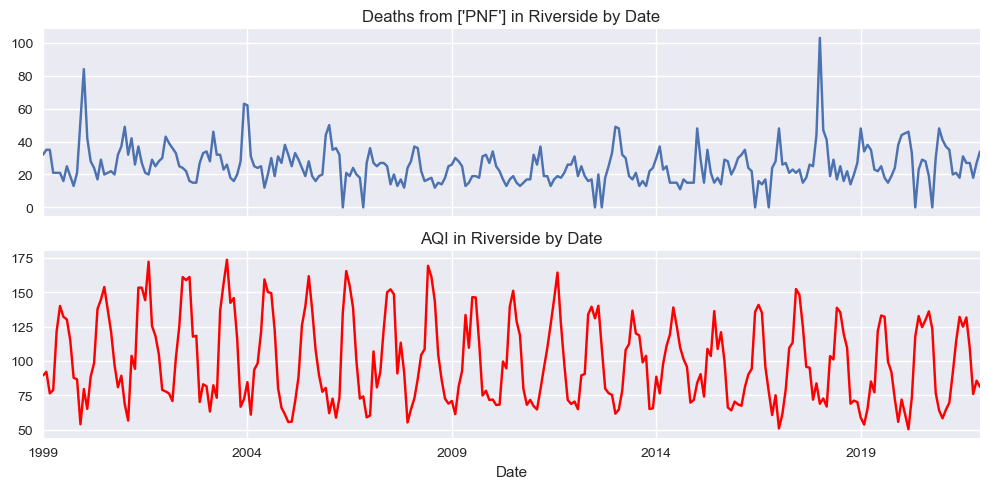

Air Quality metric: (AQI) Granger causes deaths from respiratory diseases in Riverside county with p_value of 1.0496660011008415e-06 and lag of 1


('Riverside', 'AQI', 1.0496660011008415e-06, 1, 'HTD')

In [21]:
plot_air_quality_by_county(county = 'Riverside', air_qual = 'AQI', diseases = ['PNF'], df = pneumonia_monthly, air_qual_df = pneumonia_monthly)
air_qual_test(heart_disease_monthly, 'AQI')

# Modeling

Starting Poisson Regression Model for Cause:  CLD  and Counties:  ['Kern' 'Riverside' 'San Bernardino' 'San Diego'] 
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Count   No. Observations:                   73
Model:                            GLM   Df Residuals:                       69
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3263.9
Date:                Thu, 19 Jan 2023   Deviance:                       5907.2
Time:                        17:35:40   Pearson chi2:                 5.37e+03
No. Iterations:                     4   Pseudo R-squ. (CS):             0.9897
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------

,VIF,Features
0,5.909470,Good Days
1,4.659121,Days PM2.5
2,1.735197,Days NO2


,Features,Coefficients
0,Good Days,0.001408
1,Days PM2.5,0.000421
2,Days NO2,0.002669


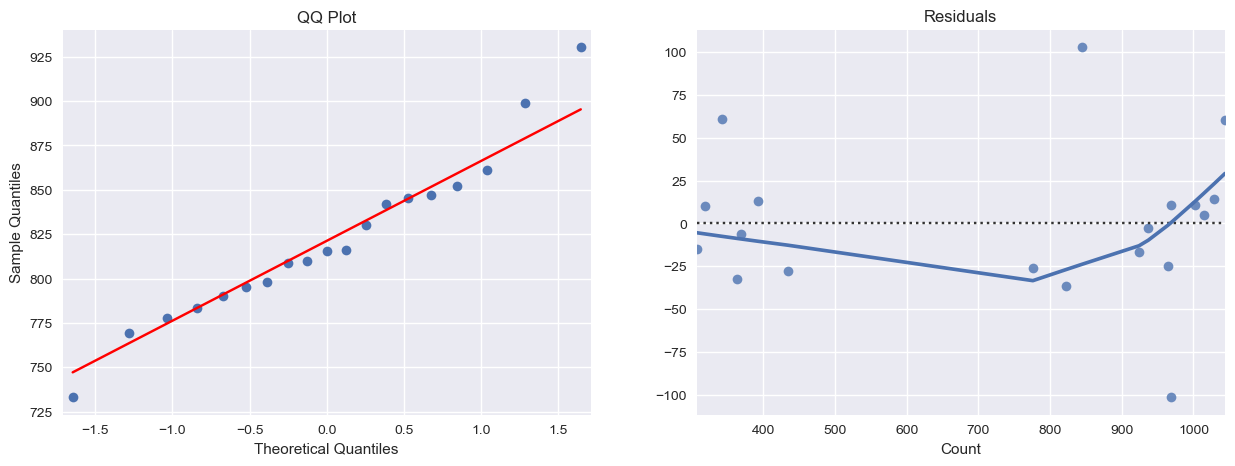

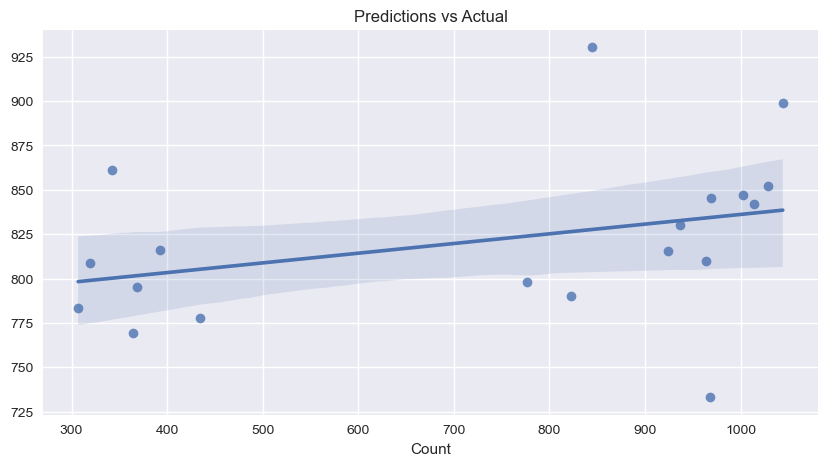

Starting Poisson Regression Model for Cause:  CAN  and Counties:  ['Kern' 'Los Angeles' 'San Bernardino' 'Tulare'] 
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Count   No. Observations:                   73
Model:                            GLM   Df Residuals:                       69
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -76501.
Date:                Thu, 19 Jan 2023   Deviance:                   1.5231e+05
Time:                        17:35:40   Pearson chi2:                 1.68e+05
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------

,VIF,Features
0,3.343213,Good Days
1,3.314042,Days PM2.5
2,1.366695,Days NO2


,Features,Coefficients
0,Good Days,-0.000193
1,Days PM2.5,0.028310
2,Days NO2,0.035579


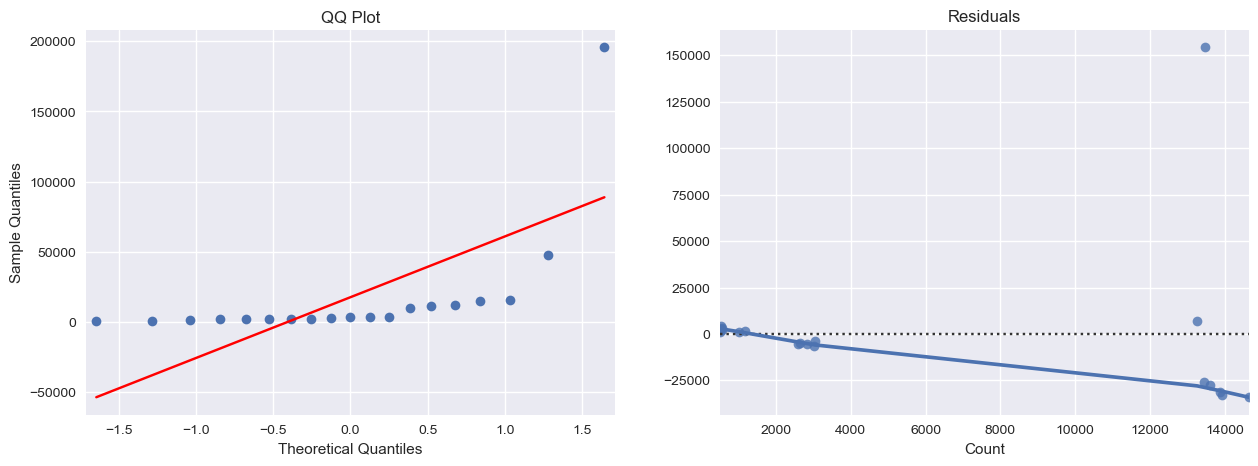

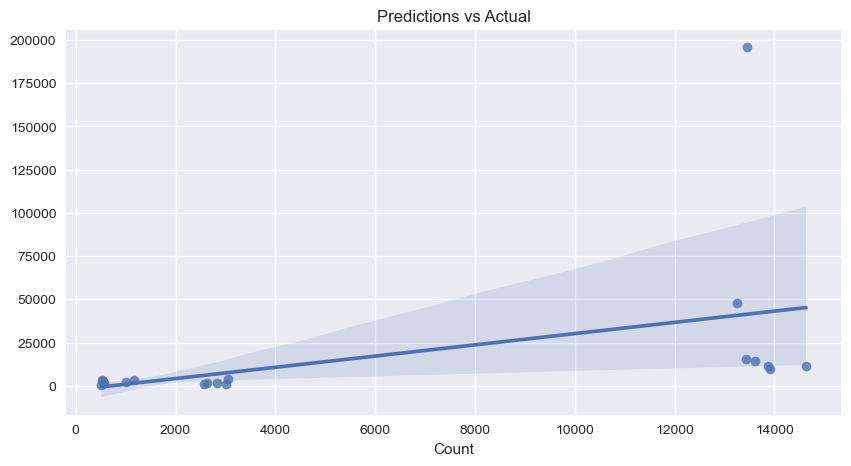

Starting Poisson Regression Model for Cause:  PNF  and Counties:  ['Kern' 'San Bernardino' 'Tulare'] 
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Count   No. Observations:                   55
Model:                            GLM   Df Residuals:                       51
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -594.19
Date:                Thu, 19 Jan 2023   Deviance:                       816.94
Time:                        17:35:41   Pearson chi2:                     856.
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------

,VIF,Features
0,4.501753,Good Days
1,3.825113,Days PM2.5
2,1.374235,Days NO2


,Features,Coefficients
0,Good Days,-0.010030
1,Days PM2.5,-0.007831
2,Days NO2,0.002740


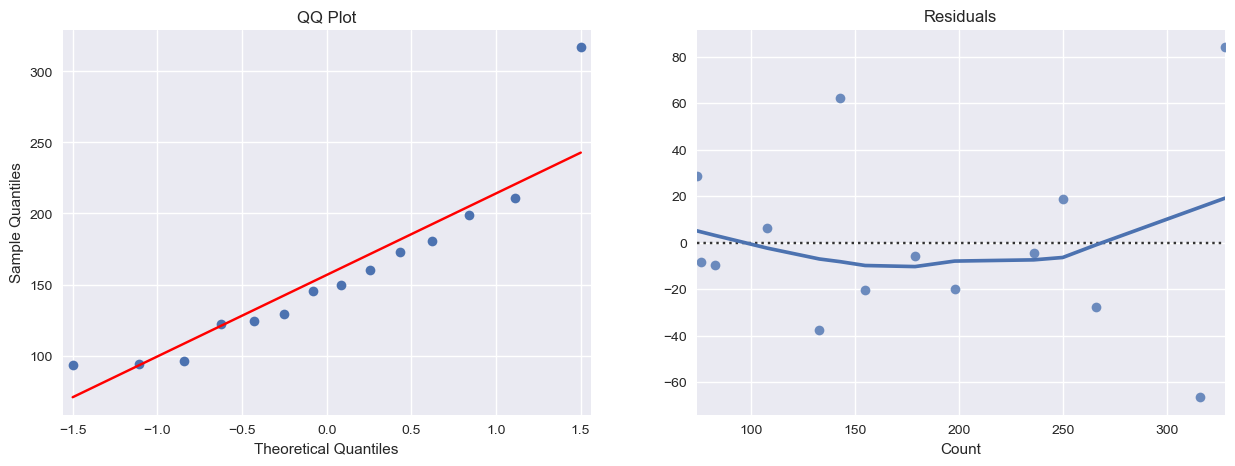

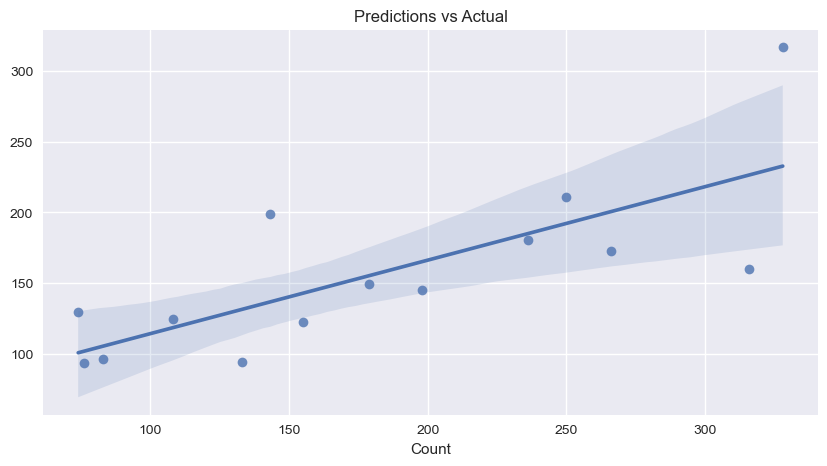

Starting Poisson Regression Model for Cause:  HTD  and Counties:  ['Imperial' 'Kern' 'Tulare'] 
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Count   No. Observations:                   55
Model:                            GLM   Df Residuals:                       51
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4391.7
Date:                Thu, 19 Jan 2023   Deviance:                       8327.9
Time:                        17:35:42   Pearson chi2:                 8.28e+03
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------

,VIF,Features
0,6.252933,Good Days
1,2.938141,Days PM2.5
2,3.418140,Days NO2


,Features,Coefficients
0,Good Days,-0.010116
1,Days PM2.5,0.000483
2,Days NO2,-0.009406


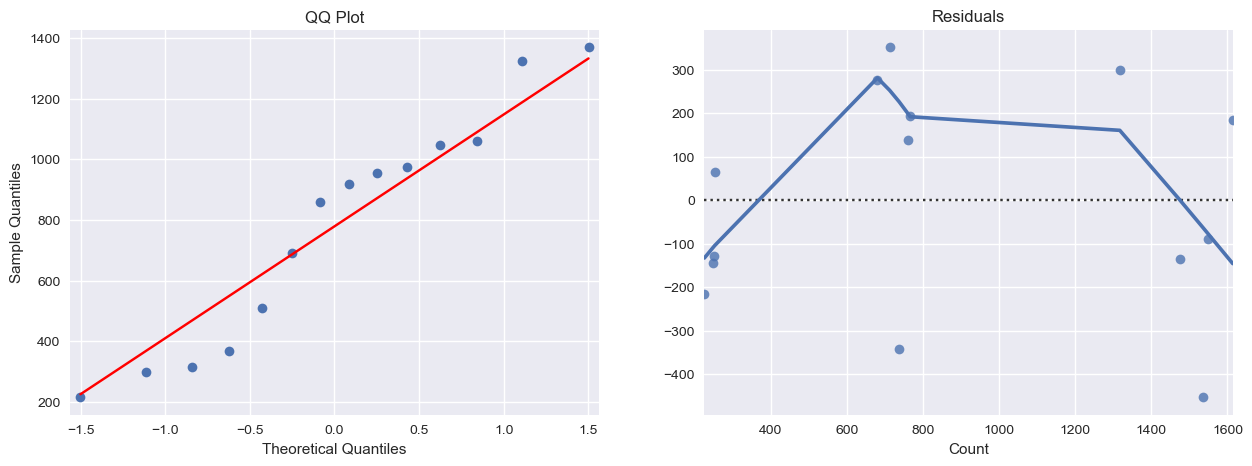

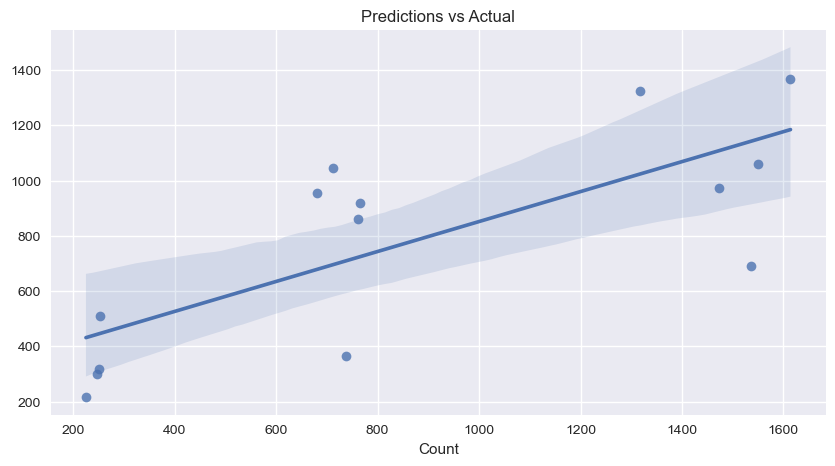

In [33]:
# poisson regression model
from sklearn.linear_model import PoissonRegressor
from sklearn.linear_model import LinearRegression
# qq plot
from statsmodels.graphics.gofplots import qqplot

# statsmodels
import statsmodels.api as sm

# poisson regression model
def poisson_regression(df,air_qual_stats):

    # get cause from df that is passed in and then query granger_df for counties that have that cause
    cause = df['Cause'].unique()[0]
    counties = granger_df.query('Cause == @cause')['County'].unique()
    print('Starting Poisson Regression Model for Cause: ', cause, ' and Counties: ', counties, '')

    # get data for county
    county_df = df.query(f'County in @counties')

    # get data for air quality stats
    X = county_df[air_qual_stats]
    y = county_df['Count']

    # train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # instantiate model
    model = PoissonRegressor(max_iter=1000, alpha=0.1)

    # # s
    # model = LinearRegression()

    # fit model
    model.fit(X_train, y_train)


    # model in statsmodels
    # add constant
    X_train_sm = sm.add_constant(X_train)

    # instantiate model
    model_sm = sm.GLM(y_train, X_train_sm, family=sm.families.Poisson())

    # fit model
    model_sm = model_sm.fit()

    # print model summary
    print(model_sm.summary())

    # get predictions
    y_pred = model.predict(X_test)

    # get vif
    vif = pd.DataFrame()
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['Features'] = X.columns
    
    display(vif)

    # get coefficients
    coef = pd.DataFrame()
    coef['Features'] = X.columns
    coef['Coefficients'] = model.coef_
    
    display(coef)

    # sub plots for predictions qq plot and residuals 
    fig, ax = plt.subplots(1,2, figsize=(15,5))
    # qq plot
    qqplot(y_pred, line='s', ax=ax[0])
    ax[0].set_title('QQ Plot')
    # residuals
    sns.residplot(x= y_test, y = y_pred, ax=ax[1], lowess=True)
    ax[1].set_title('Residuals')
    plt.show()

    # plot predictions vs actual
    plt.figure(figsize=(10,5))
    sns.regplot(x = y_test, y = y_pred)
    plt.title('Predictions vs Actual')
    plt.show()


for df in [cld, can, pneumonia, heart_disease]:

    poisson_regression(df, ['Good Days', 'Days PM2.5', 'Days NO2'])


# SPACE FOR INTERPRETATION OF MODEL RESULTS

---